# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [50]:
# Подключение Google Drive
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

# Настройка структуры папок проекта
PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'
MODELS = PROJECT_DIR / 'models'
MODELS.mkdir(exist_ok=True)

print('Проектная папка подключена:', PROJECT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [51]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасетов
train_df = pd.read_parquet(PROCESSED / 'train_features_final.parquet')
val_df = pd.read_parquet(PROCESSED / 'val_features_final.parquet')
test_df = pd.read_parquet(PROCESSED / 'test_features_final.parquet')

print(f'Train shape: {train_df.shape}')
print(f'Validation shape: {val_df.shape}')
print(f'Test shape: {test_df.shape}')

train_df.head()

Train shape: (35743638, 22)
Validation shape: (5986318, 22)
Test shape: (6005441, 22)


,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,...,snap_TX,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,CA_1,FOODS_1_001,11101,2.0,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,5,1,1.098612,0,0,0,0,0
1,CA_1,FOODS_1_001,11101,2.0,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,6,1,1.098612,0,0,0,0,0
2,CA_1,FOODS_1_001,11101,2.0,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,...,0,0,0,0,1.098612,0,0,0,0,0
3,CA_1,FOODS_1_001,11101,2.0,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,...,1,0,1,0,1.098612,0,0,0,0,0
4,CA_1,FOODS_1_001,11101,2.0,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,...,0,1,2,0,1.098612,0,0,0,0,0


In [52]:
# Находим товар и магазин с наибольшим числом изменений цены
price_changes = train_df.groupby(['item_id', 'store_id'])['sell_price'].nunique().reset_index()
price_changes.columns = ['item_id', 'store_id', 'price_changes']
price_changes.sort_values(by='price_changes', ascending=False, inplace=True)

# Выбираем топ-товар и магазин
top_item_id = price_changes.iloc[0]['item_id']
top_store_id = price_changes.iloc[0]['store_id']

print(f"Товар с максимальным числом изменений цены: {top_item_id}")
print(f"Магазин для этого товара: {top_store_id}")

price_changes.head()

Товар с максимальным числом изменений цены: FOODS_1_129
Магазин для этого товара: WI_1


,item_id,store_id,price_changes
1267,FOODS_1_129,WI_1,17
27828,HOUSEHOLD_2_250,WI_2,16
934,FOODS_1_095,TX_1,15
21446,HOUSEHOLD_1_147,TX_3,15
1268,FOODS_1_129,WI_2,15


In [53]:
# Выбор данных только для одного товара и магазина
selected_df = pd.concat([train_df, val_df, test_df])
selected_df = selected_df[(selected_df['item_id'] == top_item_id) & (selected_df['store_id'] == top_store_id)].copy()

# Подготовка агрегированного временного ряда
agg_df = selected_df.groupby('date')['log_sell_price'].mean().reset_index()
agg_df.rename(columns={'date': 'ds', 'log_sell_price': 'y'}, inplace=True)

# Проверка подготовленных данных
print(f"Количество записей в агрегированном ряде: {agg_df.shape[0]}")
agg_df.head()

Количество записей в агрегированном ряде: 1969


,ds,y
0,2011-01-29,2.254445
1,2011-01-30,2.254445
2,2011-01-31,2.254445
3,2011-02-01,2.254445
4,2011-02-02,2.254445


In [54]:
# Разделение данных на интервалы
train_df = agg_df[agg_df['ds'] < '2015-05-23']
val_df = agg_df[(agg_df['ds'] >= '2015-05-23') & (agg_df['ds'] < '2015-12-06')]
test_df = agg_df[agg_df['ds'] >= '2015-12-06']

# Вывод информации об интервалах
print(f"Train: {train_df['ds'].min().date()} - {train_df['ds'].max().date()} ({train_df.shape[0]} записей)")
print(f"Validation: {val_df['ds'].min().date()} - {val_df['ds'].max().date()} ({val_df.shape[0]} записей)")
print(f"Test: {test_df['ds'].min().date()} - {test_df['ds'].max().date()} ({test_df.shape[0]} записей)")

Train: 2011-01-29 - 2015-05-22 (1575 записей)
Validation: 2015-05-23 - 2015-12-05 (197 записей)
Test: 2015-12-06 - 2016-06-19 (197 записей)


In [55]:
from prophet import Prophet

# Список регрессоров для Prophet
regressors = ['month', 'year', 'day_of_week', 'is_weekend', 'event_flag',
              'snap_CA', 'snap_TX', 'snap_WI',
              'event_type_National', 'event_type_Cultural',
              'event_type_Religious', 'event_type_Sporting']

# Агрегируем внешние признаки по дням (средние значения)
agg_regressors = selected_df.groupby('date')[regressors].mean().reset_index()
agg_regressors.rename(columns={'date': 'ds'}, inplace=True)

# Объединяем внешние признаки с целевой переменной
prophet_df = agg_df.merge(agg_regressors, on='ds')

# Разделение данных
train_prophet = prophet_df[prophet_df['ds'] < '2015-05-23']
val_prophet = prophet_df[(prophet_df['ds'] >= '2015-05-23') & (prophet_df['ds'] < '2015-12-06')]
test_prophet = prophet_df[prophet_df['ds'] >= '2015-12-06']

# Инициализация Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Добавляем внешние регрессоры
for reg in regressors:
    model.add_regressor(reg)

# Обучаем модель
model.fit(train_prophet[['ds', 'y'] + regressors])

# Делаем прогноз на период валидации
forecast_val = model.predict(val_prophet[['ds'] + regressors])

# Проверка прогноза
forecast_val[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_jz18m8/83fykndg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_jz18m8/908s1xkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50867', 'data', 'file=/tmp/tmpm_jz18m8/83fykndg.json', 'init=/tmp/tmpm_jz18m8/908s1xkn.json', 'output', 'file=/tmp/tmpm_jz18m8/prophet_modeltzlyl9os/prophet_model-20250528231011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2015-05-23,2.042500,1.990916,2.092580
1,2015-05-24,2.041209,1.990354,2.095204
2,2015-05-25,2.030555,1.978973,2.086353
3,2015-05-26,2.039438,1.985926,2.091818
4,2015-05-27,2.039618,1.986380,2.090537


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Фактические и прогнозные значения на валидации
y_true_val = val_prophet['y'].values
y_pred_val = forecast_val['yhat'].values

# Расчёт метрик
mae = mean_absolute_error(y_true_val, y_pred_val)
mse = mean_squared_error(y_true_val, y_pred_val)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true_val - y_pred_val) / y_true_val))
r2 = r2_score(y_true_val, y_pred_val)

# Структура метрик
metrics_val = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE': mape,
    'R2': r2
}

# Выводим метрики
print("Метрики Prophet на валидации:")
for key, value in metrics_val.items():
    print(f"{key}: {value:.4f}")

Метрики Prophet на валидации:
MAE: 0.0609
MSE: 0.0045
RMSE: 0.0674
MAPE: 0.0290
R2: -9503.6349


In [57]:
# Прогноз на тестовом периоде
forecast_test = model.predict(test_prophet[['ds'] + regressors])

# Фактические и прогнозные значения на тестовом периоде
y_true_test = test_prophet['y'].values
y_pred_test = forecast_test['yhat'].values

# Расчёт метрик
mae_test = mean_absolute_error(y_true_test, y_pred_test)
mse_test = mean_squared_error(y_true_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test))
r2_test = r2_score(y_true_test, y_pred_test)

# Структура метрик на тестовом наборе
metrics_test = {
    'MAE': mae_test,
    'MSE': mse_test,
    'RMSE': rmse_test,
    'MAPE': mape_test,
    'R2': r2_test
}

# Выводим метрики на тестовом периоде
print("Метрики Prophet на тестовом периоде:")
for key, value in metrics_test.items():
    print(f"{key}: {value:.4f}")

Метрики Prophet на тестовом периоде:
MAE: 0.1028
MSE: 0.0110
RMSE: 0.1049
MAPE: 0.0487
R2: -1109.3824


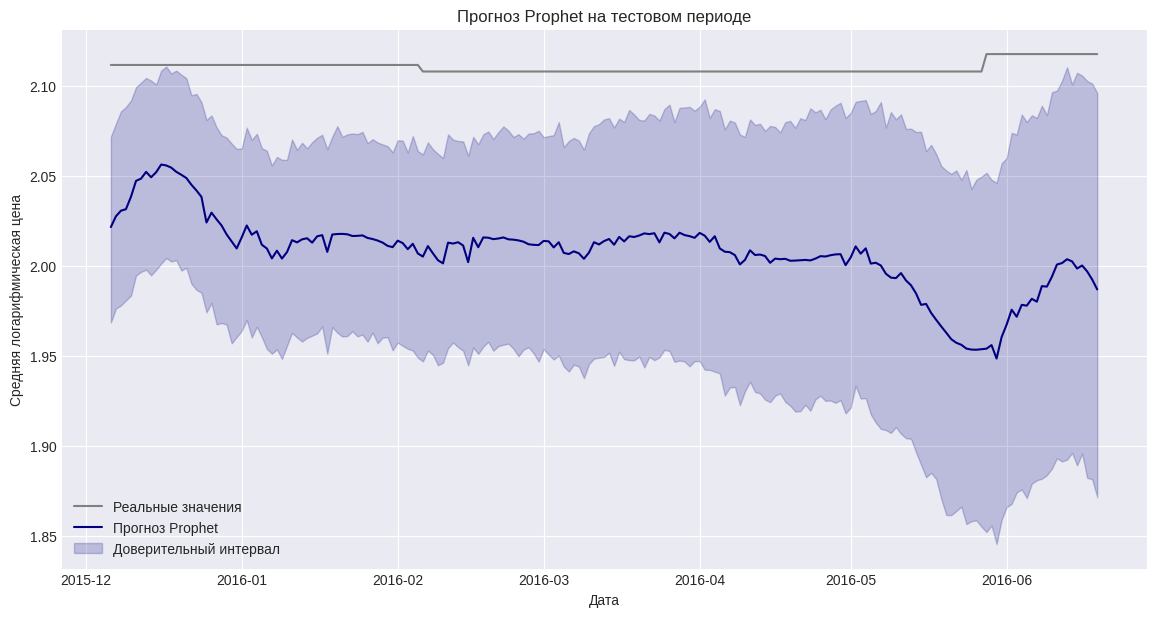

In [58]:
plt.figure(figsize=(14, 7))

# Реальные данные на тестовом периоде
plt.plot(test_prophet['ds'], test_prophet['y'], label='Реальные значения', color='gray')

# Прогноз на тестовом периоде с доверительным интервалом
plt.plot(test_prophet['ds'], forecast_test['yhat'], label='Прогноз Prophet', color='navy')
plt.fill_between(test_prophet['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='navy', alpha=0.2, label='Доверительный интервал')

plt.xlabel('Дата')
plt.ylabel('Средняя логарифмическая цена')
plt.title('Прогноз Prophet на тестовом периоде')
plt.grid(True)
plt.legend()
plt.show()

In [59]:
import pickle

# Расчет метрик на тестовом периоде
y_true_test = test_prophet['y'].values
y_pred_test = forecast_test['yhat'].values

mae = mean_absolute_error(y_true_test, y_pred_test)
mse = mean_squared_error(y_true_test, y_pred_test)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test))
r2 = r2_score(y_true_test, y_pred_test)

# Структура метрик аналогично другим моделям проекта
metrics_test = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE': mape,
    'R2': r2
}

# Сохраняем метрики
with open(MODELS / 'prophet_top_item_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_test, f)

# Сохраняем модель Prophet
with open(MODELS / 'prophet_top_item_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Финальная модель Prophet и метрики сохранены:")
print(metrics_test)

Финальная модель Prophet и метрики сохранены:
{'MAE': 0.10277737407767468, 'MSE': 0.011013358434780409, 'RMSE': np.float64(0.10494454933335227), 'MAPE': np.float64(0.048704138688153396), 'R2': -1109.3823723019887}


## Выводы по результатам обучения Prophet

- Модель Prophet продемонстрировала низкие показатели точности (R² значительно ниже нуля), что говорит о слабой способности модели объяснить изменчивость временного ряда.
- Доверительные интервалы прогнозов широкие, что свидетельствует о существенной неопределённости и нестабильности модели при прогнозировании цен конкретного товара и магазина.
- Значения метрик MAPE и RMSE существенно выше по сравнению с другими моделями, в частности ARIMA.

**Рекомендации:**
- Prophet целесообразно применять в ситуациях, где важнее общие тенденции и сезонность, а не точечный прогноз с высокой точностью.
- Для более точных прогнозов рекомендуется использовать другие модели, например, ARIMA или бустинговые модели, которые более устойчиво ведут себя при прогнозировании товаров с высокой волатильностью цен.